In [1]:
import tensorflow as tf
import numpy as np
import sys
import random
from scipy.stats import norm
import os
from sklearn.model_selection import train_test_split
from ESNN_layers import *
import pickle

In [2]:
replicates = 50
dir_path = "/Users/yzhong36/Desktop/rotation/ESNN/data"

final_cs = []
for i in range(1,replicates + 1):
#for i in [25]:

    #load example data
    X = np.loadtxt(os.path.join(dir_path, "".join(["mv_MAPIT_sim_no_same_X",str(i),".txt"])))
    Y = np.loadtxt(os.path.join(dir_path, "".join(["mv_MAPIT_sim_no_same_Y",str(i),".txt"])))
    X = X.astype('float32')
    #X = X[:,:4]
    Y = Y.astype('float32')
    sample_size = X.shape[0]
    all_indices = range(len(Y))
    shuffled_indices = tf.random.shuffle(all_indices)
    X, Y= tf.gather(X, shuffled_indices), tf.gather(Y, shuffled_indices)
    X, Y=X.numpy(), Y.numpy()
    X_train_raw_tmp, X_test_tmp, Y_train_raw_tmp, Y_test_tmp = train_test_split(X, Y, test_size=0.15)
    
    #cov_traits_tmp = [np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
    #                  np.array([[1, 0.8, 0.8], [0.8, 1, 0.8], [0.8, 0.8, 1]]),
    #                  None]
    cov_traits_tmp = [None]                  

    collection_cs = []
    for j in range(len(cov_traits_tmp)):
        #if (j == Y.shape[1]):
        #    X_train_raw = X_train_raw_tmp
        #    X_test = X_test_tmp
        #    Y_train_raw = Y_train_raw_tmp
        #    Y_test = Y_test_tmp
        X_train_raw = X_train_raw_tmp
        X_test = X_test_tmp
        Y_train_raw = Y_train_raw_tmp
        Y_test = Y_test_tmp

        cov_traits = cov_traits_tmp[j]
        #else:
        #    X_train_raw = X_train_raw_tmp
        #    X_test = X_test_tmp
        #    Y_train_raw = Y_train_raw_tmp[:,j]
        #    Y_test = Y_test_tmp[:,j]

        #parameters setup
        model_type = 'regression'
        reg_type = 'linear'
        L = 5 #number of models
        nsample = 1000 #number of samples used for approximate expectation in ELBO
        nepoch =50 #training epoch
        input_size = X.shape[1]
        if len(Y_train_raw.shape) == 1:
            output_size = 1
        else:
            output_size = Y_train_raw.shape[1]

        initial_size = X.shape[1]
        hidden_sizes = [5]# a list of numbers indicate hidden sizes
        lamb = 1.0 #weight parameter in loss function
        batch_size = 50 
        sigma = 0.0001
        temperature = 0.1 #for gumbel-softmax trick
        tau = 0.3 #for scale alpha in softmax
        mini_loss = np.mean(np.square(Y_test-np.mean(Y_test, axis = 0)))*1.0 #this is used as the threshold for purity
        l = 0
        iteration = 0
        max_iter = 5

        #run lasso for init
        from sklearn.linear_model import LassoCV
        from sklearn.linear_model import MultiTaskLassoCV
        if output_size == 1:
            clf = LassoCV(cv=5, random_state=0).fit(X_train_raw, Y_train_raw)
        else:
            clf = MultiTaskLassoCV(cv=5, random_state=0).fit(X_train_raw, Y_train_raw)
        pred_train = clf.predict(X_train_raw)
        acc_train = np.mean((Y_train_raw - pred_train)**2)
        pred_test = clf.predict(X_test)
        acc_test = np.mean((Y_test - pred_test)**2)
        print(f'Lasso Regression| train {acc_train:.4f} test {acc_test:.4f}')

        ####################################NN
        ##initializations
        #if initialize with lasso coefficient
        init_val = np.transpose(abs(clf.coef_))
        init_val = init_val.astype('float32')
        
        if output_size == 1:
            init_val = np.reshape(init_val, (input_size, 1))

        #model
        all_model = list()
        model = SNN(model_type, reg_type, sigma, input_size, output_size, cov_traits, hidden_sizes, temperature, tau, False, init_val)
        all_myloss = list()
        all_prbs = list()
        #all_cs = list()
        all_cs = [[] for i in range(output_size)]
        while l<L and iteration<= max_iter:
            myloss = np.zeros((nepoch, 4))
            for epoch in range(0, nepoch):
                learning_rate = 0.005*(0.995**epoch) # for classification
                model.optimizer = tf.optimizers.Adam(learning_rate = learning_rate)
                all_indices = range(len(Y_train_raw))
                shuffled_indices = tf.random.shuffle(all_indices)
                train_bnn(model, tf.gather(X_train_raw, shuffled_indices), tf.gather(Y_train_raw, shuffled_indices), batch_size, learning_rate, True, nsample, 0.00005, 10.0)#0.00005
                pred, nll, kl = model.call(X_train_raw, Y_train_raw, True, 100)
                if output_size == 1:
                    temp_train_acc = np.mean(tf.losses.MSE(pred[:,:,0], Y_train_raw))
                else:
                    temp_train_acc = np.mean(tf.losses.MSE(pred, Y_train_raw))
                pred, temp_test_nll, kl = model.call(X_test, Y_test, True, 100)
                if output_size == 1:
                    temp_test_acc = np.mean(tf.losses.MSE(pred[:,:,0], Y_test))
                else:
                    temp_test_acc = np.mean(tf.losses.MSE(pred, Y_test))
                elbo = nll+kl
                myloss[epoch,0] = elbo
                myloss[epoch,1] = temp_train_acc
                # myloss[epoch,2] = temp_val_acc
                myloss[epoch,2] = temp_test_acc
                print("Iteration", iteration)
                print("Train loss", temp_train_acc)
                print("l", l)
                print("mini loss", mini_loss)
                print("Test loss", temp_test_acc)
                #prbs = np.asarray(tf.nn.softmax(model.bnn.w_alpha[:,0]/tau))
                prbs = np.asarray(tf.map_fn(tf.nn.softmax, tf.transpose(model.bnn.w_alpha/tau)))
                print('#################################################################################################################')
                for i in range(prbs.shape[0]):
                    print("Trait",i+1,":")
                    print(np.where(prbs[i,]>0.1))
                    print(np.where(prbs[i,] == np.max(prbs[i,])))
                #print(np.where(prbs>0.1))
                #print(np.where(prbs == np.max(prbs)))
                
                #cov = tf.matmul(tf.transpose(model.bnn.cov_decomp,perm=[0,1,3,2]), tf.transpose(model.bnn.cov_decomp,perm=[0,1,2,3]))
                #cov = model.bnn.cov
                #print(cov[0,0,:,:])
                if epoch>3 and model_type == 'regression' and temp_test_acc<mini_loss - 0.05:
                    break
                if epoch>10 and model_type == 'regression' and temp_test_acc<mini_loss - 0.02:
                    break
                if epoch > 30:
                    curr_avg = np.max(myloss[epoch-2:epoch,2])
                    pre_avg = np.max(myloss[epoch-4:epoch-2,2])
                    if model_type == 'regression' and curr_avg>= pre_avg:
                        break
            if model_type == 'regression' and myloss[epoch,2]<=mini_loss-0.01:
                mini_loss = myloss[epoch,2]
                l += 1
                all_myloss.append(myloss)
                all_model.append(model)
                #temp_prbs = np.asarray(tf.nn.softmax(model.bnn.w_alpha[:,0]/tau))
                temp_prbs = np.asarray(tf.map_fn(tf.nn.softmax, tf.transpose(model.bnn.w_alpha/tau)))
                if temp_prbs.shape[1]<initial_size:
                    #if len(all_cs) == 1:
                        #toinsert = np.unique(all_cs[0])
                    #else:
                    toinsert = np.unique(np.concatenate(sum(all_cs, [])))
                    temp_to_add = temp_prbs
                    for pos in toinsert:
                        temp_to_add = np.insert(temp_to_add, pos, 1e-10, axis = 1)
                    all_prbs.append(temp_to_add)
                else:
                    temp_to_add = temp_prbs
                    all_prbs.append(temp_to_add)
                #derive residuals
                pred, nll, kl = model.call(X_train_raw, Y_train_raw, True, 100)
                if output_size == 1:
                    res_train = np.mean(pred[:,:,0], axis = 0) - Y_train_raw
                else:
                    res_train = np.mean(pred, axis = 0) - Y_train_raw
                pred, temp_test_nll, kl = model.call(X_test, Y_test, True, 100)
                if output_size == 1:
                    res_test = np.mean(pred[:,:,0], axis = 0) - Y_test
                else:
                    res_test = np.mean(pred, axis = 0) - Y_test
                Y_train_raw = res_train
                Y_test = res_test
                #compute cs
                nsnp = temp_prbs.shape[1]
                temp_cs_list = []
                 
                for trait in range(temp_prbs.shape[0]):
                    for temp_j in range(nsnp):
                        cs_idx = nsnp-temp_j
                        if sum(np.sort(temp_prbs[trait,:])[cs_idx:])>0.95:
                            break
                    temp_cs = np.argsort(temp_prbs[trait,:])[cs_idx:]
                    if temp_cs.shape[0]>1:
                        cc = np.corrcoef(np.transpose(X[:,temp_cs]))
                        for k in range(cc.shape[0]):
                            cc[k][k]=0.5
                    else:
                        cc = 0.5
                    if np.min(cc)>=0.5:
                        #print("temp_cs: ", temp_cs)
                        #print("cc: ",cc)
                        # all_cs.append(temp_cs)
                        #remove found variables
                        temp_cs_list.append(temp_cs)
                        #add cs with correct idx
                        #print("temp_to_add shape: ", temp_to_add.shape)
                        nsnp = temp_to_add.shape[1]
                        for temp_j in range(nsnp):
                            cs_idx = nsnp-temp_j
                            if sum(np.sort(temp_to_add[trait,:])[cs_idx:])>0.95:
                                break
                        temp_cs = np.argsort(temp_to_add[trait,:])[cs_idx:]
                        all_cs[trait].append(temp_cs)

                if len(temp_cs_list) > 0:
                    temp_cs = np.unique(np.concatenate(temp_cs_list))
                    print("Regress out: ", temp_cs)
                    print("Prob: ", temp_prbs[:, temp_cs])
                    X_train_raw = np.delete(X_train_raw, temp_cs, axis = 1)
                    X_test = np.delete(X_test, temp_cs, axis = 1)
                    input_size = X_train_raw.shape[1]
                
            #if len(all_cs)>0:
            print("Current CS: ",all_cs)
            if len(sum(all_cs, [])) > 0:
                temp_init_val = tf.random.truncated_normal([input_size, output_size], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32)
            else:
                temp_init_val = init_val
            model = SNN(model_type, reg_type, sigma, input_size, output_size, cov_traits, hidden_sizes, temperature, tau, False, temp_init_val)
            iteration+=1

        collection_cs.append(all_cs)
    final_cs.append(collection_cs)

Lasso Regression| train 0.6644 test 0.6478
sampling a cov matrix ...


2023-03-15 00:17:03.921973: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Iteration 0
Train loss 1.071161
l 0
mini loss 0.9190822243690491
Test loss 1.0175755
#################################################################################################################
Trait 1 :
(array([ 47, 143]),)
(array([143]),)
Trait 2 :
(array([99]),)
(array([99]),)
Trait 3 :
(array([ 20,  57, 126]),)
(array([57]),)
Iteration 0
Train loss 0.8903458
l 0
mini loss 0.9190822243690491
Test loss 0.8740131
#################################################################################################################
Trait 1 :
(array([ 47, 143]),)
(array([143]),)
Trait 2 :
(array([99]),)
(array([99]),)
Trait 3 :
(array([57]),)
(array([57]),)
Iteration 0
Train loss 0.8846126
l 0
mini loss 0.9190822243690491
Test loss 0.8519875
#################################################################################################################
Trait 1 :
(array([143]),)
(array([143]),)
Trait 2 :
(array([99]),)
(array([99]),)
Trait 3 :
(array([57]),)
(array([57]),)
Iteration 0
Tr

2023-03-15 01:18:52.215958: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Iteration 0
Train loss nan
l 0
mini loss 0.9462143182754517
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 0
Train loss nan
l 0
mini loss 0.9462143182754517
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 0
Train loss nan
l 0
mini loss 0.9462143182754517
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Tr

2023-03-15 02:06:17.908855: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Iteration 3
Train loss nan
l 2
mini loss 0.7674379348754883
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 3
Train loss nan
l 2
mini loss 0.7674379348754883
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 3
Train loss nan
l 2
mini loss 0.7674379348754883
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Tr

2023-03-15 03:35:43.360707: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Iteration 5
Train loss nan
l 2
mini loss 0.8498361706733704
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 5
Train loss nan
l 2
mini loss 0.8498361706733704
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 5
Train loss nan
l 2
mini loss 0.8498361706733704
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Tr

2023-03-15 03:51:42.984842: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Iteration 1
Train loss nan
l 1
mini loss 0.8761386275291443
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 1
Train loss nan
l 1
mini loss 0.8761386275291443
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 1
Train loss nan
l 1
mini loss 0.8761386275291443
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Tr

2023-03-15 09:04:54.341782: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Iteration 1
Train loss nan
l 1
mini loss 0.8830286264419556
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 1
Train loss nan
l 1
mini loss 0.8830286264419556
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 1
Train loss nan
l 1
mini loss 0.8830286264419556
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Tr

2023-03-15 10:05:38.042492: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Iteration 0
Train loss nan
l 0
mini loss 0.9276005029678345
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 0
Train loss nan
l 0
mini loss 0.9276005029678345
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 0
Train loss nan
l 0
mini loss 0.9276005029678345
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Tr

2023-03-15 10:23:38.098975: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Iteration 1
Train loss nan
l 1
mini loss 0.9082599878311157
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 1
Train loss nan
l 1
mini loss 0.9082599878311157
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 2 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Trait 3 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Iteration 1
Train loss nan
l 1
mini loss 0.9082599878311157
Test loss nan
#################################################################################################################
Trait 1 :
(array([], dtype=int64),)
(array([], dtype=int64),)
Tr

In [3]:
mv_cov_cs = final_cs

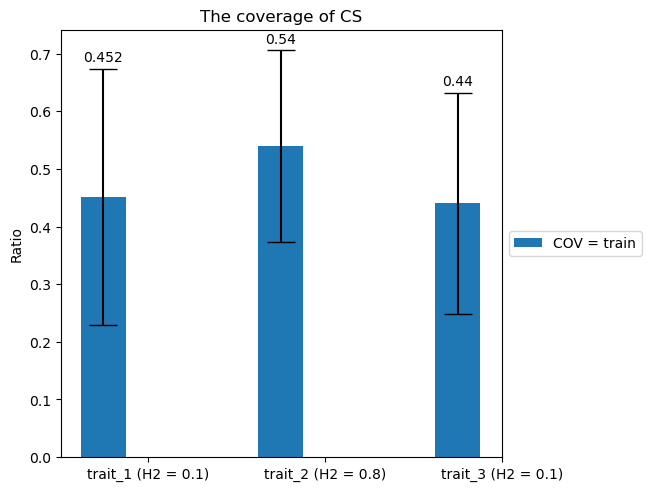

In [7]:
import matplotlib.pyplot as plt

mv_cs_0_1 = []
mv_cs_0_2 = []
mv_cs_0_3 = []

for i in range(replicates):
    for j in range(1):
        for k in range(3):

            if j == 0:
                if k == 0:
                    mv_cs_0_1.append(mv_cov_cs[i][j][k])
                if k == 1:
                    mv_cs_0_2.append(mv_cov_cs[i][j][k])
                if k == 2:
                    mv_cs_0_3.append(mv_cov_cs[i][j][k])


mv_cs_0_1_c = []
for i in mv_cs_0_1:
    mv_cs_0_1_c.append(len(i)/5)

mv_cs_0_2_c = []
for i in mv_cs_0_2:
    mv_cs_0_2_c.append(len(i)/5)

mv_cs_0_3_c = []
for i in mv_cs_0_3:
    mv_cs_0_3_c.append(len(i)/5)


mv_cs_0_1_c_m = np.mean(mv_cs_0_1_c); mv_cs_0_1_c_sd = np.std(mv_cs_0_1_c)
mv_cs_0_2_c_m = np.mean(mv_cs_0_2_c); mv_cs_0_2_c_sd = np.std(mv_cs_0_2_c)
mv_cs_0_3_c_m = np.mean(mv_cs_0_3_c); mv_cs_0_3_c_sd = np.std(mv_cs_0_3_c)

traits = ("trait_1 (H2 = 0.1)", "trait_2 (H2 = 0.8)", "trait_3 (H2 = 0.1)")
cs_means = {
    'COV = train': ((mv_cs_0_1_c_m, mv_cs_0_2_c_m, mv_cs_0_3_c_m), (mv_cs_0_1_c_sd, mv_cs_0_2_c_sd, mv_cs_0_3_c_sd))
}

x = np.arange(len(traits))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in cs_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[0], width, label=attribute, 
    yerr = measurement[1], align='center', ecolor='black',capsize=10)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Ratio')
ax.set_title('The coverage of CS')
ax.set_xticks(x + width, traits)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()